In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchAA import torchAA
from torchNMF import NMF
from ShiftNMFDiscTau import ShiftNMF
from torchShiftAA import torchShiftAA
from torchShiftAADiscTau import torchShiftAADisc
import torch
from helpers.callbacks import explained_variance
import scipy.io

## Data

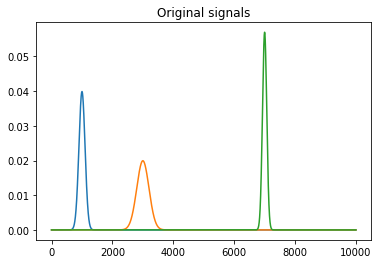

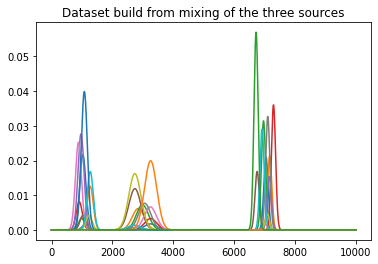

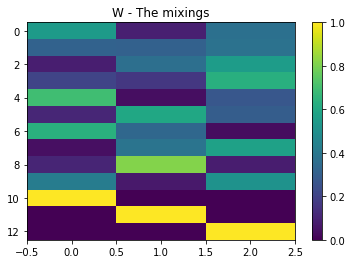

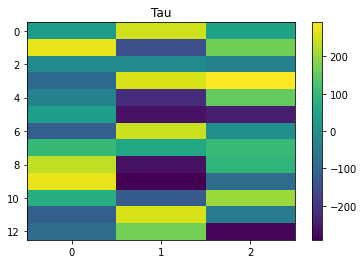

Tau Norm:  1095.5861444907014


In [4]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 10, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

shift = 300

def gauss(mu, s, time):
    return 1/(s*np.sqrt(2*np.pi))*np.exp(-1/2*((time-mu)/s)**2)


def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V


# Random mixings:
W = np.random.dirichlet(np.ones(d), N)
W = np.append(W, [[1,0,0]], axis=0)
W = np.append(W, [[0,1,0]], axis=0)
W = np.append(W, [[0,0,1]], axis=0)
N = N+3

# Random gaussian shifts
tau = np.random.randint(-shift, shift, size=(N, d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [100, 300, 700]
std = [10, 20, 7]
t = np.arange(0, 1000, 0.1)
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])
plt.figure()
for signal in H:
    plt.plot(signal)
plt.title("Original signals")
plt.show()

X = shift_dataset(W, H, tau)
X_clean = shift_dataset(W, H, np.zeros((N, d)))

plt.figure()
for signal in X:
    plt.plot(signal.real)
plt.title("Dataset build from mixing of the three sources")
plt.show()
plt.figure()
plt.imshow(W, aspect='auto', interpolation="none")
plt.colorbar()
plt.title("W - The mixings")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()


print("Tau Norm: ", np.linalg.norm(tau))

## Sinc-interpolation

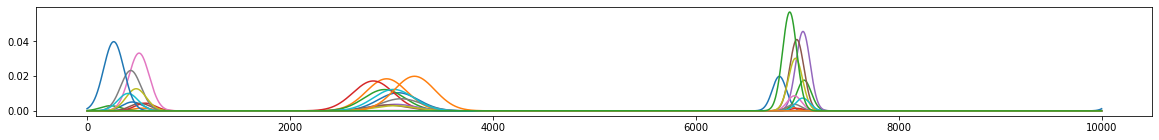

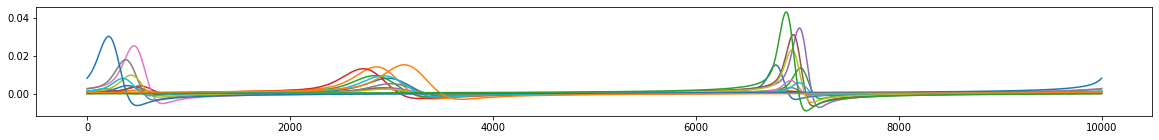

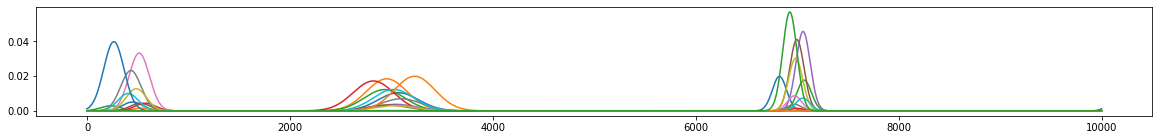

In [113]:
tau_0 = np.round(np.random.randn(N, d)*100)
tau_half = tau_0 + 0.2
tau_1 = tau_0 + 1

N, M, d = 10, 10000, 3

W_sinc = np.random.dirichlet(np.ones(d), N)
W_sinc = np.append(W_sinc, [[1,0,0]], axis=0)
W_sinc = np.append(W_sinc, [[0,1,0]], axis=0)
W_sinc = np.append(W_sinc, [[0,0,1]], axis=0)
N += 3
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])

X_0 = shift_dataset(W_sinc, H, tau_0)
X_half = shift_dataset(W_sinc, H, tau_half)
X_1 = shift_dataset(W_sinc, H, tau_1)

plt.plot(X_0.T)
plt.show()
plt.plot(X_half.T)
plt.show()
plt.plot(X_1.T)
plt.show()

In [120]:
print(explained_variance(X_0, X_1))
print(explained_variance(X_half, X_1))

0.999929895664503
0.46454569092767795


## Regular NMF

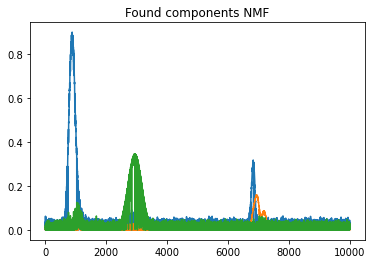

UsageError: Line magic function `%` not found.


In [7]:

nmf = NMF(X, 3, lr=0.4, factor=0.5, alpha=1e-4)
W, H = nmf.fit(verbose=True)
recon = np.matmul(W, H)

for signal in H:
    plt.plot(signal)
plt.title("Found components NMF")
plt.show()
%
plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

## Shift NMF

In [12]:

nmf = ShiftNMF(X, 1, lr=0.4, factor=0.9)
W, H, tau = nmf.fit(verbose=True, max_iter=30000, tau_iter=20000)


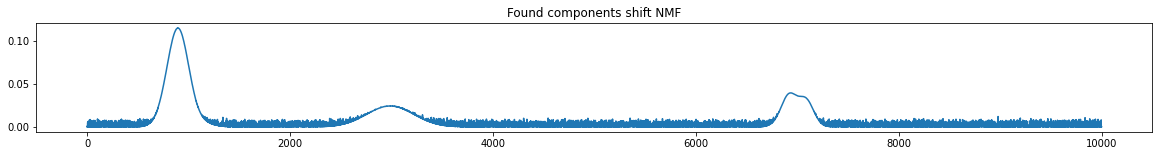

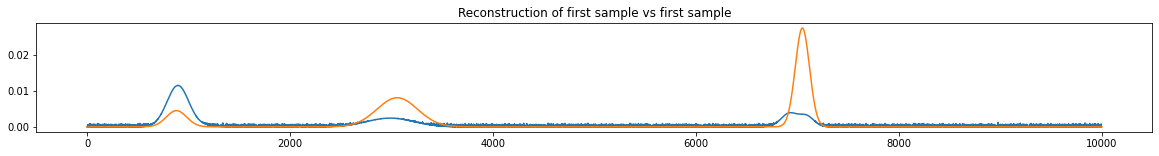

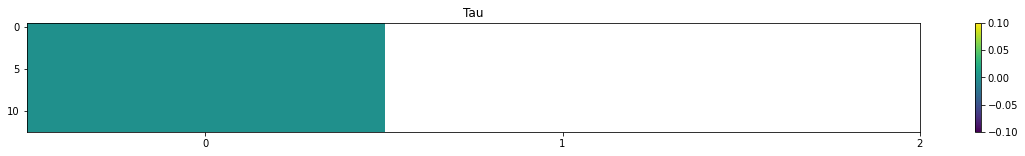

In [13]:
recon = nmf.recon.detach().numpy()

for signal in H:
    plt.plot(signal)
plt.title("Found components shift NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

plt.figure()
plt.imshow(tau[:13], aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()

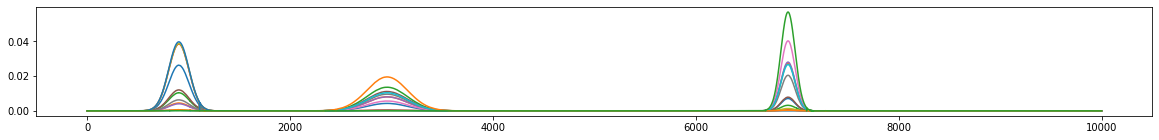

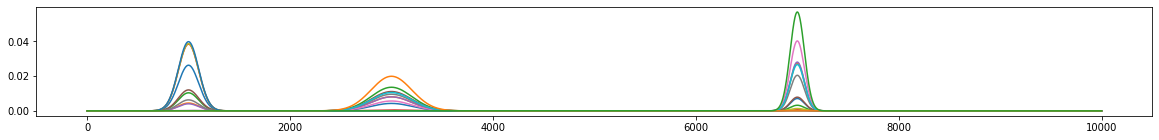

In [4]:
plt.rcParams['figure.figsize'] = [20, 2]
plt.plot(np.matmul(W,H).T)
plt.show()
plt.plot(X_clean.T)
plt.show()

## Regular AA

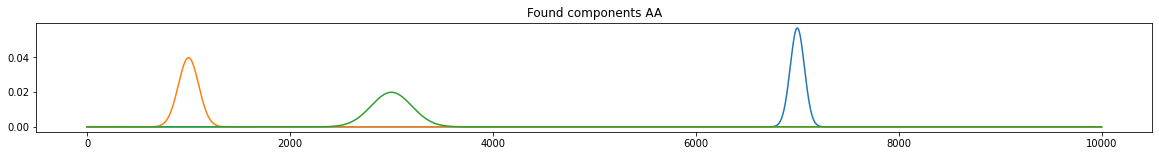

In [6]:
AA = torchAA(X_clean, 3, patience = 10, alpha=1e-5, lr=0.3)
# AA.C = C_init
# AA.S = S_init
C, S = AA.fit(verbose=True)
CX = np.matmul(C, X_clean)
recon_reg = np.matmul(S, CX)

C_init = AA.C
S_init = AA.S


plt.rcParams['figure.figsize'] = [20, 2]
for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()



# plt.plot(recon[1])
# plt.plot(X[1])
# plt.title("Reconstruction of first sample vs first sample (AA)")
# plt.show()

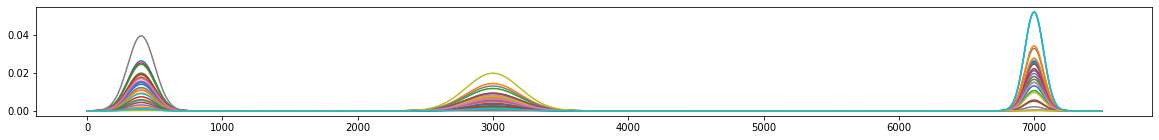

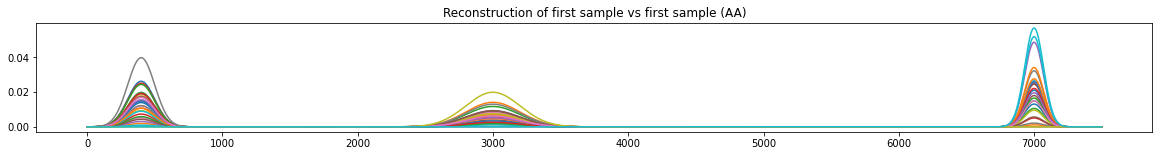

In [198]:
plt.plot(recon_reg.T[:7500])
plt.show()
plt.plot(X_clean.T[:7500])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

## Shift AA

In [3]:
# mat = scipy.io.loadmat('helpers/data/NMR_mix_DoE.mat')

# #Get X and Labels. Probably different for the other dataset, but i didn't check :)
# X = mat.get('xData')
# X = X[:10]
AA = torchShiftAA(X_clean, 3, lr=0.3, patience=5, alpha=1e-5, factor=0.9)
# AA.C_tilde = C_init
# AA.C_tilde = torch.nn.Parameter(AA.C_tilde, requires_grad=True)

# AA.S_tilde = S_init
# AA.S_tilde = torch.nn.Parameter(AA.S_tilde, requires_grad=True)

# AA.tau_tilde = torch.nn.Parameter(torch.tensor(tau, dtype=torch.float32), requires_grad=True)

# C, S, _ = AA.fit(verbose=True)

recon = AA.recon.detach().resolve_conj().numpy()
A = torch.fft.ifft(AA.A_F).detach().numpy()

CX = A
SCX = recon

recon_no_shift = np.matmul(S,A)

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

# plt.plot(recon.T)
# plt.plot(X.T)
# plt.title("Reconstruction of first sample vs first sample (AA)")
# plt.show()



AttributeError: 'torchShiftAA' object has no attribute 'recon'

In [ ]:
plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("True Tau")
plt.show()

plt.figure()
plt.imshow(_, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau Found")
plt.show()

In [ ]:
#change figure size
lim = 7500

plt.plot(recon_no_shift.T[:lim])
plt.show()
plt.plot(recon_reg.T[:lim])
plt.show()
plt.plot(X_clean.T[:lim])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

In [ ]:
# tau = AA.fit(verbose=True)

# recon = AA.recon.detach().resolve_conj().numpy()
# A = torch.fft.ifft(AA.A_F).detach().numpy()

# CX = A
# SCX = recon

# for signal in CX:
#     plt.plot(signal)
# plt.title("Found components AA")
# plt.show()

# # plt.plot(recon.T)
# # plt.plot(X.T)
# # plt.title("Reconstruction of first sample vs first sample (AA)")
# # plt.show()



In [ ]:
def expl_var(rec, original):
    return 1-(np.linalg.norm(original - rec, ord="fro")**2 / np.linalg.norm(original - np.mean(original), ord="fro")**2)

In [ ]:
print("Explained variance AA reg: ", expl_var(recon_reg, X_clean))
print("Explained variance AA: ", expl_var(recon, X_clean))

Explained variance AA reg:  1.0
Explained variance AA:  0.721666933107004


In [ ]:
print(explained_variance(recon_reg, X_clean))
print(np.real(explained_variance(recon, X_clean)))

1.0
0.6410087052129281


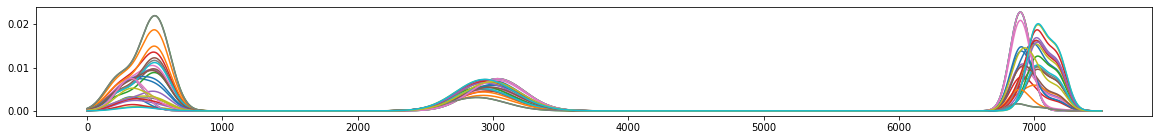

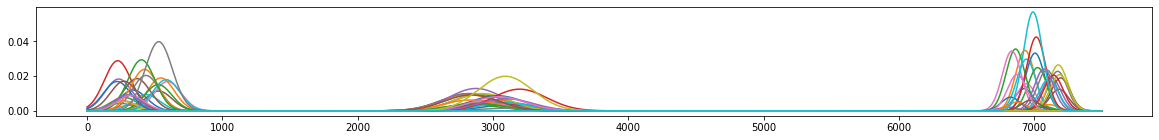

Explained variance AA shift:  0.5898671558274242


In [217]:
recon_shift = AA.recon.detach().numpy()
plt.plot(recon_shift.T[:lim])
plt.show()
plt.plot(X.T[:lim])
plt.show()
print("Explained variance AA shift: ", expl_var(recon_shift, X_clean))

In [7]:
AA = torchShiftAADisc(X, 3, lr=0.3, patience=5, alpha=1e-5, factor=0.999, fs_init=True)
# AA.C_tilde = C_init
# AA.C_tilde = torch.nn.Parameter(AA.C_tilde, requires_grad=True)

# AA.S_tilde = S_init
# AA.S_tilde = torch.nn.Parameter(AA.S_tilde, requires_grad=True)


AA.tau_tilde = torch.nn.Parameter(torch.tensor(tau, dtype=torch.float32), requires_grad=True)

C, S, tau_AA_shift = AA.fit(verbose=True, max_iter=500, tau_thres=1e-5)

KeyboardInterrupt: 

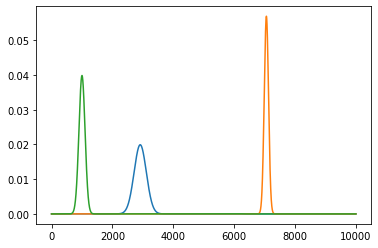

In [36]:

recon = AA.recon.detach().resolve_conj().numpy()
A = torch.fft.ifft(AA.A_F).detach().numpy()

A_mm = np.matmul(AA.C().detach().numpy(), X)

CX = A
SCX = recon

recon_no_shift = np.matmul(S,A)

# for signal in A:
plt.plot(A.T)
# plt.title("Found components AA")
# plt.show()

# plt.plot(X_clean[-3:].T)
# plt.title("Original Components")
plt.show()

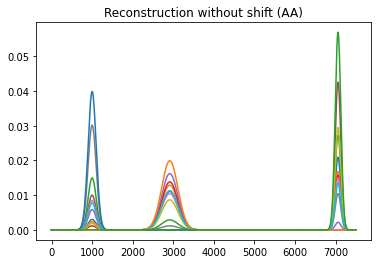

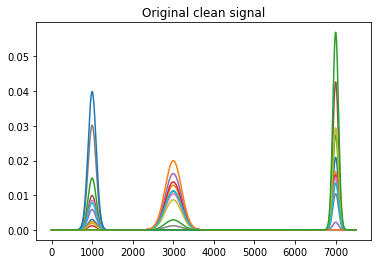

In [38]:
lim = 7500

plt.plot(recon_no_shift.T[:lim])
plt.title("Reconstruction without shift (AA)")
plt.show()
# plt.plot(recon_reg.T[:lim])
# plt.show()
plt.plot(X_clean.T[:lim])
plt.title("Original clean signal")
plt.show()

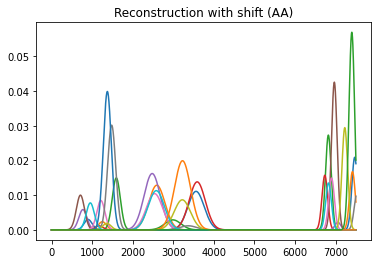

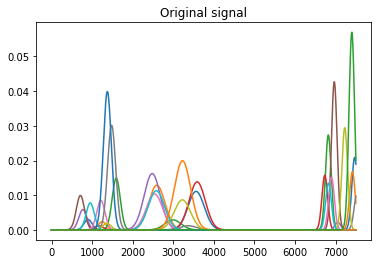

In [37]:
plt.plot(recon.T[:lim])
plt.title("Reconstruction with shift (AA)")
plt.show()
# plt.plot(recon_reg.T[:lim])
# plt.show()
plt.plot(X.T[:lim])
plt.title("Original signal")
plt.show()

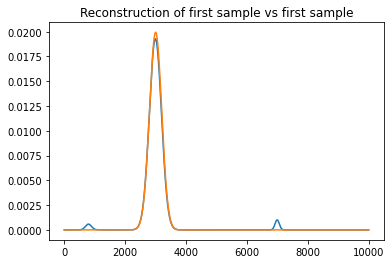

In [8]:
plt.plot(recon_no_shift[11])
plt.plot(X_clean[11])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

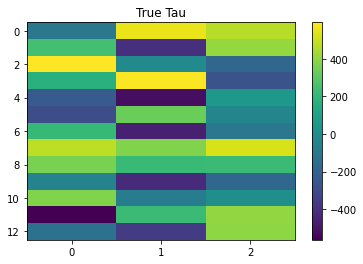

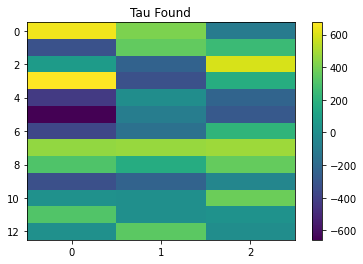

In [39]:
# plt.figure()
plt.imshow(tau[:13], aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("True Tau")
plt.show()

plt.figure()
plt.imshow(tau_AA_shift[:13], aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau Found")
plt.show()

In [16]:
def AA_recon(S_aa, C_aa, X_dat, tau_found):
    N, M = X_dat.shape
    
    f = np.arange(0, M) / M
    
    omega = np.exp(-2j * np.pi * np.einsum('Nd,M->NdM', tau_found, f))
    omega_conj = np.conj(omega)
    
    X_F = np.fft.fft(X_dat)
    
    X_F_align = np.einsum('NM,NdM->NdM', X_F, omega_conj)
    
    A_F = np.einsum('dN,NdM->dM', C_aa, X_F_align)
    S_shift = np.einsum('Nd,NdM->NdM', S_aa, omega)
    
    x = np.einsum('NdM,dM->NM', S_shift, A_F)
    return np.fft.ifft(x)

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


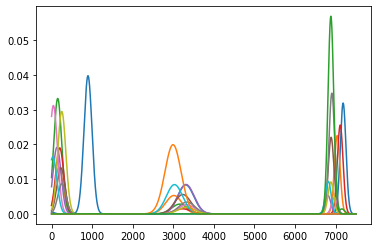

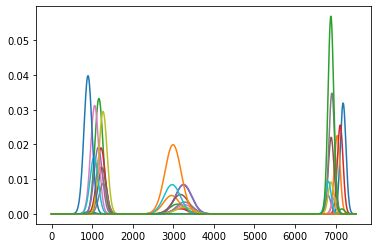

In [26]:
# X_rec_func = AA_recon(S, C, X, _)

plt.plot(AA_recon(S, C, X, tau_AA_shift).T[:lim])
plt.show()
plt.plot(AA_recon(S, C, X, tau).T[:lim])
plt.show()

In [212]:
np.linalg.norm(AA_recon(S, C, X, tau) - AA_recon(S, C, X, _), ord="fro")**2 / np.linalg.norm(AA_recon(S, C, X, tau) - np.mean(AA_recon(S, C, X, tau)), ord="fro")**2

0.8338747572522093

In [10]:
tau

array([[ 129, -137,  184],
       [-164,  121,   38],
       [ -21,   88,  153],
       [  50,  139,  112],
       [ 135,   71, -188],
       [  57,  167, -111],
       [ 152,  -16,  -27],
       [ 157,  190,  -94],
       [ 143,  190, -116],
       [-149,  -31, -181],
       [-102, -181, -180],
       [-127,   -7,  141],
       [ 172,  182, -118]])

In [12]:
#swap column 0 and 1
tau_AA_shift[:,[0, 1]] = tau_AA_shift[:,[1, 0]]

In [27]:
tau_AA_shift

array([[ 120., -166.,  168.],
       [-172.,   94.,   22.],
       [ -28.,   60.,  136.],
       [  42.,  110.,   96.],
       [ 128.,   42., -206.],
       [  50.,  138., -128.],
       [ 144.,  -46.,  -44.],
       [ 150.,  162., -110.],
       [ 136.,  160., -134.],
       [-156.,  -60., -198.],
       [-110.,  806., -120.],
       [-192.,  -36., -884.],
       [-684., -408., -134.]])

In [23]:
#add 100 to the last column
tau_AA_shift[:,-1] -= 200

In [30]:
C.shape

(3, 13)